<a href="https://colab.research.google.com/github/kartikdutt18/LANL-Earthquake-Prediction/blob/master/Earthquake_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [2]:
#to access kaggle datasets
!pip install kaggle
#Math operations
!pip install numpy
#Machine learning
!pip install catboost

In [0]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanninjiraya","key":"029eb9a1829579424675948b90febd0c"}'}

In [4]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 68 Feb 10 15:18 kaggle.json


# **Downloading the Dataset**

In [8]:
!kaggle competitions download -c LANL-Earthquake-Prediction

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!ls
!unzip train.csv.zip

catboost_info	       seg_42648c.csv  seg_8456d3.csv  seg_c20c06.csv
kaggle.json	       seg_4280d9.csv  seg_845a2a.csv  seg_c21723.csv
sample_data	       seg_428d66.csv  seg_8472f3.csv  seg_c21d60.csv
sample_submission.csv  seg_42c4c9.csv  seg_848695.csv  seg_c22bd4.csv
seg_00030f.csv	       seg_42e7e8.csv  seg_84a65d.csv  seg_c23429.csv
seg_0012b5.csv	       seg_42ff14.csv  seg_84b9d9.csv  seg_c23641.csv
seg_00184e.csv	       seg_430e66.csv  seg_84c7fb.csv  seg_c243a6.csv
seg_003339.csv	       seg_43383f.csv  seg_84fc12.csv  seg_c24946.csv
seg_0042cc.csv	       seg_434c96.csv  seg_8509db.csv  seg_c25855.csv
seg_004314.csv	       seg_43597f.csv  seg_850d95.csv  seg_c267a5.csv
seg_004cd2.csv	       seg_43c6f4.csv  seg_8515fd.csv  seg_c26fb4.csv
seg_004ee5.csv	       seg_440106.csv  seg_853302.csv  seg_c27591.csv
seg_004f1f.csv	       seg_4401d8.csv  seg_854d91.csv  seg_c2a0c8.csv
seg_00648a.csv	       seg_441c6d.csv  seg_857304.csv  seg_c2b8f7.csv
seg_006e4a.csv	       seg_4435bd.csv  se

In [10]:
!ls

kaggle.json  sample_submission.csv  train.csv
sample_data  test.zip		    train.csv.zip


In [0]:
!rm train.csv.zip

In [12]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.zip  train.csv


In [0]:
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [7]:
train.head(5)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


# Visualize

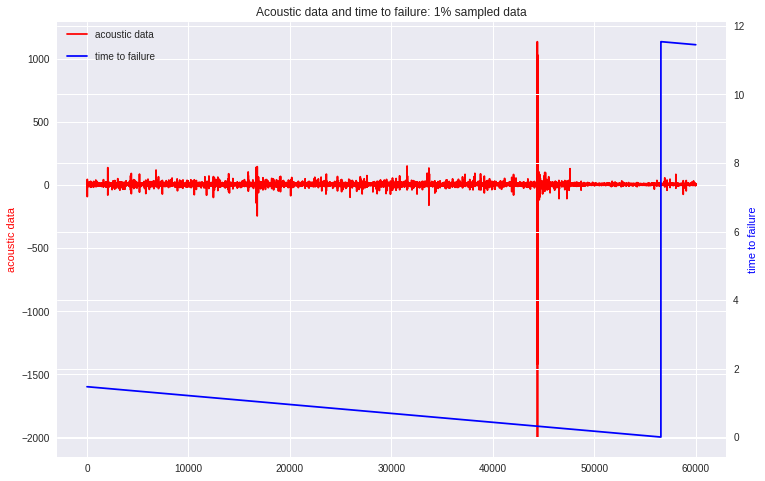

In [8]:
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)

# **Adding Features**

In [0]:
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [11]:
train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.7804224713035586}}

In [23]:
!ls

catboost_info  sample_data	      test.zip
kaggle.json    sample_submission.csv  train.csv


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}


In [28]:
!ls
!unzip test.zip

catboost_info  sample_data	      test.zip
kaggle.json    sample_submission.csv  train.csv
Archive:  test.zip
  inflating: seg_430e66.csv          
  inflating: seg_d1a281.csv          
  inflating: seg_05a1b0.csv          
  inflating: seg_f8dd7e.csv          
  inflating: seg_b9bdd7.csv          
  inflating: seg_24c1c9.csv          
  inflating: seg_c5abaa.csv          
  inflating: seg_6262c4.csv          
  inflating: seg_734a88.csv          
  inflating: seg_94a133.csv          
  inflating: seg_d0c280.csv          
  inflating: seg_d36737.csv          
  inflating: seg_f80e44.csv          
  inflating: seg_07c815.csv          
  inflating: seg_7c9433.csv          
  inflating: seg_211486.csv          
  inflating: seg_78ded2.csv          
  inflating: seg_f11f77.csv          
  inflating: seg_b3883e.csv          
  inflating: seg_3db0a8.csv          
  inflating: seg_81f798.csv          
  inflating: seg_0a45a1.csv          
  inflating: seg_dc188b.csv          
  inflating: seg_

In [29]:
!ls

catboost_info	       seg_42648c.csv  seg_8456d3.csv  seg_c20c06.csv
kaggle.json	       seg_4280d9.csv  seg_845a2a.csv  seg_c21723.csv
sample_data	       seg_428d66.csv  seg_8472f3.csv  seg_c21d60.csv
sample_submission.csv  seg_42c4c9.csv  seg_848695.csv  seg_c22bd4.csv
seg_00030f.csv	       seg_42e7e8.csv  seg_84a65d.csv  seg_c23429.csv
seg_0012b5.csv	       seg_42ff14.csv  seg_84b9d9.csv  seg_c23641.csv
seg_00184e.csv	       seg_430e66.csv  seg_84c7fb.csv  seg_c243a6.csv
seg_003339.csv	       seg_43383f.csv  seg_84fc12.csv  seg_c24946.csv
seg_0042cc.csv	       seg_434c96.csv  seg_8509db.csv  seg_c25855.csv
seg_004314.csv	       seg_43597f.csv  seg_850d95.csv  seg_c267a5.csv
seg_004cd2.csv	       seg_43c6f4.csv  seg_8515fd.csv  seg_c26fb4.csv
seg_004ee5.csv	       seg_440106.csv  seg_853302.csv  seg_c27591.csv
seg_004f1f.csv	       seg_4401d8.csv  seg_854d91.csv  seg_c2a0c8.csv
seg_00648a.csv	       seg_441c6d.csv  seg_857304.csv  seg_c2b8f7.csv
seg_006e4a.csv	       seg_4435bd.csv  se

In [14]:
test1=pd.read_csv('seg_04b87a.csv')
test1.head(5)

,acoustic_data
0,6
1,10
2,11
3,5
4,7


In [0]:
def tester(a):  
  test = pd.read_csv(a, iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16})

  X_test = pd.DataFrame()
  y_test = pd.Series()
  for df in test:
      ch = gen_features(df['acoustic_data'])
      X_test = X_test.append(ch, ignore_index=True)

  X_test= scaler.transform(X_test)
  return reg1.predict(X_test)
  
  

In [0]:
sub=pd.read_csv('sample_submission.csv')

In [38]:
for i in range(len(sub)):
  a=sub.iloc[i][0]+'.csv'
  print(a)
  [b]=tester(a)
  print(b)
  sub.loc[i,'time_to_failure']=b
  print(8*'*',' ',(i+1)*100/len(sub),' Percentage Completed ',8*'*')

seg_00030f.csv
5.0121400711695205
********   0.038109756097560975  Percentage Completed  ********
seg_0012b5.csv
5.2271867338363895
********   0.07621951219512195  Percentage Completed  ********
seg_00184e.csv
5.250232576341576
********   0.11432926829268293  Percentage Completed  ********
seg_003339.csv
7.4238452000371495
********   0.1524390243902439  Percentage Completed  ********
seg_0042cc.csv
6.389103839698037
********   0.19054878048780488  Percentage Completed  ********
seg_004314.csv
4.157657107005408
********   0.22865853658536586  Percentage Completed  ********
seg_004cd2.csv
6.608828772014573
********   0.26676829268292684  Percentage Completed  ********
seg_004ee5.csv
3.1095188938039664
********   0.3048780487804878  Percentage Completed  ********
seg_004f1f.csv
4.569245597446407
********   0.3429878048780488  Percentage Completed  ********
seg_00648a.csv
3.117575172353856
********   0.38109756097560976  Percentage Completed  ********
seg_006e4a.csv
2.992501841069519
*****

In [0]:
sub.to_csv('sub_2.csv', index=False)

In [0]:
from google.colab import files
files.download('sub_2.csv')